<a href="https://colab.research.google.com/github/fericazatti/CUDA_GPU_INTRODUCTION/blob/main/ICNPG_fusion_numpy_cupy_thrust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%html
<marquee style='width: 100%; color: blue;'><b>ICNPG2025 en Google Colaboratory-Instituto Balseiro</b></marquee>


In [ ]:
#@title si sale un error sobre UTF, probablemente se arregle corriendo esto
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

miremos que version de nvcc tenemos

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


A ver que placa nos toco...

In [ ]:
!nvidia-smi

Mon Feb 24 12:59:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Experimentos con distintos frameworks



Sean dos vectores $x$ e $y$, queremos calcular

$$S=\frac{\sum_{i=0}^n  (x_i+y_i)}{\sqrt{\sum_{i=0}^n (x_i+y_i)^2}}=\frac{\sum_{i=0}^n  z_i}{\sqrt{\sum_{i=0}^n z_i^2}}$$

In [ ]:
#@title naive python

import numpy as np
import time

n = 10000000

# create x and y vectors
x = np.arange(1, n+1, dtype=np.float32)
y = np.arange(n, 0, -1, dtype=np.float32)
z= np.empty(x.shape, dtype=np.float32)

###################
start_time = time.time()

# fill z vector
for i in range(n):
  z[i] = x[i] + y[i]

# normalize z by its Euclidean norm
norm=0
for i in range(n):
  norm += z[i] * z[i]
norm = np.sqrt(norm)

# sum the elements of the final result
#result = np.sum(z)/norm

result = 0;
for i in range(n):
  result += z[i];
result = result/norm


# print the result and the time taken
print("Result:", result)
print("Time taken:", (time.time() - start_time) * 1000000, "us")
###################

tnaivepython = (time.time() - start_time) * 1000000
#print(x,y,z,z_norm)

Result: 3162.2777051668395
Time taken: 12553514.003753662 us


In [ ]:
#@title Naive C
%%writefile naivec.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>

int main() {
    int n = 10000000;
    float *x = (float *)malloc(n * sizeof(float));
    float *y = (float *)malloc(n * sizeof(float));
    float *z = (float *)malloc(n * sizeof(float));

    // create x and y vectors
    for (int i = 0; i < n; i++) {
        x[i] = i + 1;
        y[i] = n - i;
    }

    clock_t start_time = clock();

    // fill z vector
    for (int i = 0; i < n; i++) {
        z[i] = x[i] + y[i];
    }

    // normalize z by its Euclidean norm
    float norm = 0;
    for (int i = 0; i < n; i++) {
        norm += z[i] * z[i];
    }
    norm = sqrtf(norm);

    // sum the elements of the final result
    float sum_z = 0;
    for(int i = 0; i < n; i++){
        sum_z += z[i];
    }
    float result = sum_z / norm;


    // print the result and the time taken
    printf("Result: %f\n", result);
    printf("Time taken: %f us\n", (double)(clock() - start_time) / CLOCKS_PER_SEC * 1000000);

    free(x);
    free(y);
    free(z);
    return 0;
}


Writing naivec.c


In [ ]:
!g++ -O4 naivec.c -o naivec; ./naivec

Result: 3029.677002
Time taken: 49861.000000 us


In [ ]:
import os

# Get the value of the bash variable
stream = os.popen('./naivec | grep "Time" | cut -d" " -f3') #note that we use echo to print the variable in bash, and os.popen to grab it into the python runtime
t_value = stream.read().strip()  # Read and remove any trailing newline

# Define the Python variable
tnaivec = float(t_value)

# Now you can use python_var in your Python code
print(tnaivec)

49469.0


In [ ]:
#@title Naive cpp and stl

%%writefile naivecpp.cpp
#include <iostream>
#include <vector>
#include <numeric>
#include <cmath>
#include <chrono>
#include <algorithm>


int main() {
    int n = 10000000;
    std::vector<float> x(n), y(n), z(n);

    // create x and y vectors
    for (int i = 0; i < n; i++) {
        x[i] = i + 1;
        y[i] = n - i;
    }

    auto start_time = std::chrono::high_resolution_clock::now();

    // fill z vector
    std::transform(x.begin(), x.end(), y.begin(), z.begin(), std::plus<float>());

    // normalize z by its Euclidean norm
    float norm = std::sqrt(std::inner_product(z.begin(), z.end(), z.begin(), 0.0f));

    // sum the elements of the final result
    float sum_z = std::accumulate(z.begin(), z.end(), 0.0f);
    float result = sum_z / norm;

    auto end_time = std::chrono::high_resolution_clock::now();
    auto time_taken = std::chrono::duration_cast<std::chrono::microseconds>(end_time - start_time).count();

    // print the result and the time taken
    std::cout << "Result: " << result << std::endl;
    std::cout << "Time taken: " << time_taken << " us" << std::endl;

    return 0;
}

Writing naivecpp.cpp


In [ ]:
!g++ -O4 naivecpp.cpp -o naivecpp; ./naivecpp

Result: 3029.68
Time taken: 36015 us


In [ ]:
import os

# Get the value of the bash variable
stream = os.popen('./naivecpp | grep "Time" | cut -d" " -f3') #note that we use echo to print the variable in bash, and os.popen to grab it into the python runtime
t_value = stream.read().strip()  # Read and remove any trailing newline

# Define the Python variable
tnaivecpp = float(t_value)

# Now you can use python_var in your Python code
print(tnaivecpp)

35772.0


In [ ]:
#@title numpy
import numpy as np
import time

n = 10000000

# create x and y vectors
x = np.arange(1, n+1, dtype=np.float32)
y = np.arange(n, 0, -1, dtype=np.float32)
z= np.empty(x.shape, dtype=np.float32)

###################
start_time = time.time()

# fill z vector
z = x + y

# normalize z by its Euclidean norm
norm = np.linalg.norm(z)
#z_norm = z / norm

# sum the elements of the final result
result = np.sum(z)/norm

# print the result and the time taken
print("Result:", result)
print("Time taken:", (time.time() - start_time) * 1000000, "us")
###################

tnumpy = (time.time() - start_time) * 1000000
#print(x,y,z,z_norm)

Result: 3161.5037
Time taken: 23064.136505126953 us


In [ ]:
#@title cupy (solo cambiar np->cp !!!)
import cupy as cp
import time

n = 10000000

# create x and y vectors
x = cp.arange(1, n+1, dtype=cp.float32)
y = cp.arange(n, 0, -1, dtype=cp.float32)
z= cp.empty(x.shape, dtype=cp.float32)

###################
start_time = time.time()

# fill z vector
z = x + y

# normalize z by its Euclidean norm
norm = cp.linalg.norm(z)
#z_norm = z / norm

# sum the elements of the final result
result = cp.sum(z)/norm

# print the result and the time taken
print("Result:", result)
cp.cuda.Stream.null.synchronize()
print("Time taken:", (time.time() - start_time) * 1000000, "us")
###################

tcupy = (time.time() - start_time) * 1000000

#print(x,y,z,z_norm)

Result: 3162.2773
Time taken: 1477.7183532714844 us


In [ ]:
#@title thrust
%%writefile exp.cu
#include <thrust/device_vector.h>
#include <thrust/transform_reduce.h>
#include <thrust/reduce.h>
#include <thrust/sequence.h>
#include <thrust/iterator/counting_iterator.h>
#include <thrust/functional.h>
#include <thrust/execution_policy.h>
#include <cmath>
#include <iostream>
#include <chrono>

int main()
{
    int n = 10000000;

    // create x and y vectors
    thrust::device_vector<float> x(n);
    thrust::device_vector<float> y(n);
    thrust::sequence(x.begin(), x.end(), 1.f);
    thrust::sequence(y.rbegin(), y.rend(), 1.f);

    // create z vector
    thrust::device_vector<float> z(n);

    auto start_time = std::chrono::high_resolution_clock::now();

    // initialize z = x + y
    thrust::transform(thrust::device, x.begin(), x.end(), y.begin(), z.begin(), thrust::plus<float>());

    // normalize z by its Euclidean norm (transform and reduce fused)
    float norm = std::sqrt(thrust::transform_reduce(thrust::device, z.begin(), z.end(), thrust::square<float>(), 0.f, thrust::plus<float>()));

    // sum the elements of the final result
    float result = thrust::reduce(thrust::device, z.begin(), z.end(), 0.f, thrust::plus<float>())/norm;

    // print the result and the time taken
    std::cout << "Result: " << result << std::endl;

    cudaDeviceSynchronize();
    auto end_time = std::chrono::high_resolution_clock::now();

    auto time_taken = std::chrono::duration_cast<std::chrono::microseconds>(end_time - start_time).count();
    std::cout << "Time taken: " << time_taken << " us" << std::endl;

    return 0;
}


Overwriting exp.cu


In [ ]:
!nvcc -O2 -arch=sm_75 exp.cu; ./a.out > zzz; ./a.out

Result: 3162.28
Time taken: 1355 us


In [ ]:
!./a.out | grep "Time" | cut -d" " -f3

1579


In [ ]:
import os

# Get the value of the bash variable
stream = os.popen('./a.out | grep "Time" | cut -d" " -f3') #note that we use echo to print the variable in bash, and os.popen to grab it into the python runtime
t_value = stream.read().strip()  # Read and remove any trailing newline

# Define the Python variable
tthrust = float(t_value)

# Now you can use python_var in your Python code
print(tthrust)

1355.0


In [ ]:
#@title thrust optimized
%%writefile exp2.cu
#include <thrust/device_vector.h>
#include <thrust/transform_reduce.h>
#include <thrust/reduce.h>
#include <thrust/iterator/counting_iterator.h>
#include <thrust/iterator/zip_iterator.h>
#include <thrust/functional.h>
#include <thrust/execution_policy.h>
#include <thrust/tuple.h>
#include <cmath>
#include <iostream>
#include <chrono>
#include <thrust/sequence.h>


int main()
{
    int n = 10000000;
    //n=4;

    // create x and y vectors
    thrust::device_vector<float> x(n);
    thrust::device_vector<float> y(n);
    thrust::sequence(x.begin(), x.end(), 1.f);
    thrust::sequence(y.rbegin(), y.rend(), 1.f);

    auto start_time = std::chrono::high_resolution_clock::now();

    auto ambos =
    thrust::transform_reduce(thrust::device,
      thrust::make_zip_iterator(
        thrust::make_tuple(x.begin(),y.begin())
      ),
      thrust::make_zip_iterator(
        thrust::make_tuple(x.end(),y.end())
      ),
      [=] __host__ __device__ (thrust::tuple<float, float> tup)
      {
          float x=thrust::get<0>(tup);
          float y=thrust::get<1>(tup);
          return
          thrust::make_tuple(
            x+y,
            (x+y)*(x+y)
          );
      },
      thrust::make_tuple(0.f,0.f),
      [=] __host__ __device__ (thrust::tuple<float, float> tup1, thrust::tuple<float, float> tup2)
      {
          return
          thrust::make_tuple(
            thrust::get<0>(tup1)+thrust::get<0>(tup2),
            thrust::get<1>(tup1)+thrust::get<1>(tup2)
          );
      }
    );

    float numerador=thrust::get<0>(ambos);
    float denominador=thrust::get<1>(ambos);

    float result=numerador/sqrt(denominador);

    // print the result and the time taken
    std::cout << "Result: " << result << std::endl;

    #ifdef __CUDACC__
    std::cout << "cuda on" << std::endl;
    cudaDeviceSynchronize();
    #endif

    auto end_time = std::chrono::high_resolution_clock::now();

    auto time_taken = std::chrono::duration_cast<std::chrono::microseconds>(end_time - start_time).count();
    std::cout << "Time taken: " << time_taken << " us" << std::endl;

    return 0;
}


Writing exp2.cu


In [ ]:
!nvcc -O2 -arch=sm_75 --extended-lambda  exp2.cu -o exp2 ; ./exp2

Result: 3162.28
cuda on
Time taken: 914 us


In [ ]:
import os

# Get the value of the bash variable
stream = os.popen('./exp2 | grep "Time" | cut -d" " -f3') #note that we use echo to print the variable in bash, and os.popen to grab it into the python runtime
t_value = stream.read().strip()  # Read and remove any trailing newline

# Define the Python variable
tthrust2 = float(t_value)

# Now you can use python_var in your Python code
print(tthrust2)

731.0


In [ ]:
!cp exp2.cu exp2.cpp;
!g++ -O2 -I/content/thrust/ -I/usr/local/cuda/include -DTHRUST_DEVICE_SYSTEM=THRUST_DEVICE_SYSTEM_CPP exp2.cpp  -o portableCPU ; ./portableCPU

Result: 3029.68
Time taken: 14017 us


In [ ]:
import os

# Get the value of the bash variable
stream = os.popen('./portableCPU | grep "Time" | cut -d" " -f3') #note that we use echo to print the variable in bash, and os.popen to grab it into the python runtime
t_value = stream.read().strip()  # Read and remove any trailing newline

# Define the Python variable
tthrust3 = float(t_value)

# Now you can use python_var in your Python code
print(tthrust3)

14099.0


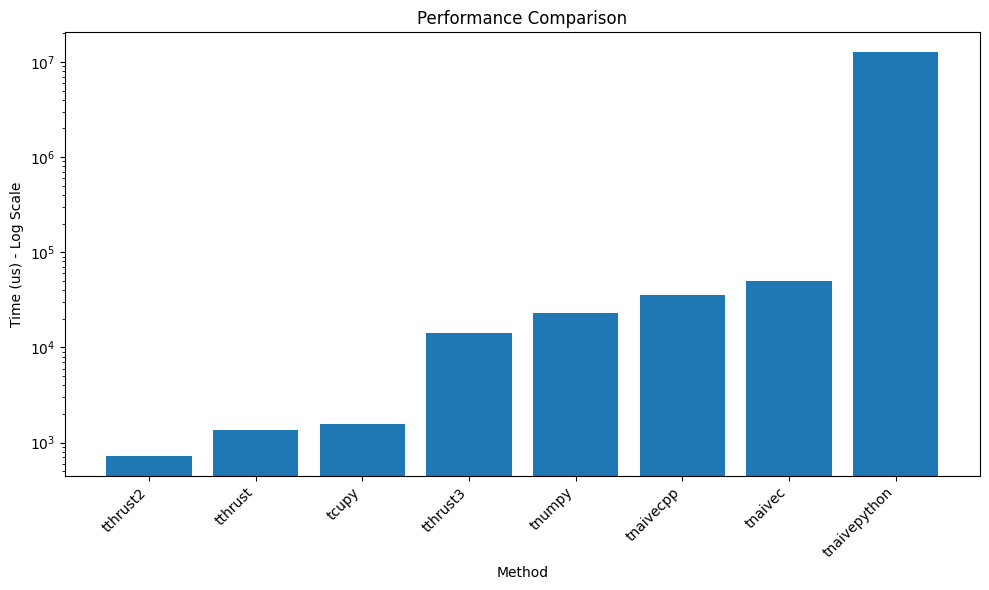

In [ ]:
#@title Comparacion performance
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
performance_data = {
    'tthrust2': tthrust2,
    'tthrust': tthrust,
    'tcupy': tcupy,
    'tthrust3': tthrust3,
    'tnumpy': tnumpy,
    'tnaivecpp': tnaivecpp,
    'tnaivec': tnaivec,
    'tnaivepython': tnaivepython
}

# Extract labels and values
labels = list(performance_data.keys())
values = list(performance_data.values())

# Create the bar chart with log y-scale
plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.yscale('log')
plt.xlabel("Method")
plt.ylabel("Time (us) - Log Scale")
plt.title("Performance Comparison")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


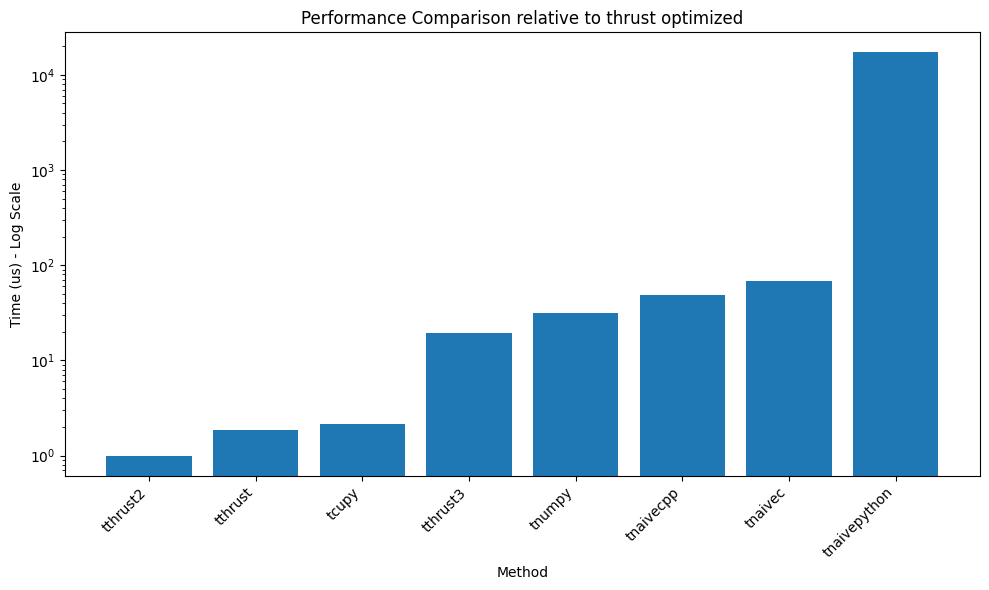

In [ ]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
performance_data = {
    'tthrust2': tthrust2/tthrust2,
    'tthrust': tthrust/tthrust2,
    'tcupy': tcupy/tthrust2,
    'tthrust3': tthrust3/tthrust2,
    'tnumpy': tnumpy/tthrust2,
    'tnaivecpp': tnaivecpp/tthrust2,
    'tnaivec': tnaivec/tthrust2,
    'tnaivepython': tnaivepython/tthrust2
}

# Extract labels and values
labels = list(performance_data.keys())
values = list(performance_data.values())

# Create the bar chart with log y-scale
plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.yscale('log')
plt.xlabel("Method")
plt.ylabel("Time (us) - Log Scale")
plt.title("Performance Comparison relative to thrust optimized")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


# Install last Thrust

In [ ]:
!git clone --recursive https://github.com/NVIDIA/thrust.git

Cloning into 'thrust'...
remote: Enumerating objects: 50516, done.
remote: Counting objects: 100% (234/234), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 50516 (delta 98), reused 199 (delta 85), pack-reused 50282 (from 1)
Receiving objects: 100% (50516/50516), 17.35 MiB | 19.12 MiB/s, done.
Resolving deltas: 100% (40174/40174), done.
Submodule 'cub' (https://github.com/NVIDIA/cub.git) registered for path 'dependencies/cub'
Submodule 'libcudacxx' (https://github.com/NVIDIA/libcudacxx.git) registered for path 'dependencies/libcudacxx'
Cloning into '/content/thrust/dependencies/cub'...
remote: Enumerating objects: 33392, done.        
remote: Counting objects: 100% (247/247), done.        
remote: Compressing objects: 100% (63/63), done.        
remote: Total 33392 (delta 209), reused 184 (delta 184), pack-reused 33145 (from 4)        
Receiving objects: 100% (33392/33392), 18.00 MiB | 27.31 MiB/s, done.
Resolving deltas: 100% (27972/27972), done.
Cloning into '/